Download a real world dataset containing at least 1000 samples and more than 10 features. Perform exploratory data analysis to understand the dataset's structure. Apply Linear Discriminant Analysis for dimensionality reduction, ensuring class separability. Visualize the transformed dataset using different linear discriminants and analyze the effectiveness of LDA in improving class separation.

In [42]:
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
plt.style.use('ggplot')

In [43]:
wine_quality = fetch_ucirepo(id=186)
wq_X = wine_quality.data.features
wq_y = wine_quality.data.targets

In [64]:
wq_y.value_counts()

quality
6          2836
5          2138
7          1079
4           216
8           193
3            30
9             5
Name: count, dtype: int64

In [45]:
wq_X

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0               7.4              0.70         0.00             1.9      0.076   
1               7.8              0.88         0.00             2.6      0.098   
2               7.8              0.76         0.04             2.3      0.092   
3              11.2              0.28         0.56             1.9      0.075   
4               7.4              0.70         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
6492            6.2              0.21         0.29             1.6      0.039   
6493            6.6              0.32         0.36             8.0      0.047   
6494            6.5              0.24         0.19             1.2      0.041   
6495            5.5              0.29         0.30             1.1      0.022   
6496            6.0              0.21         0.38             0.8      0.020   

      free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                    11.0                  34.0  0.99780  3.51       0.56   
1                    25.0                  67.0  0.99680  3.20       0.68   
2                    15.0                  54.0  0.99700  3.26       0.65   
3                    17.0                  60.0  0.99800  3.16       0.58   
4                    11.0                  34.0  0.99780  3.51       0.56   
...                   ...                   ...      ...   ...        ...   
6492                 24.0                  92.0  0.99114  3.27       0.50   
6493                 57.0                 168.0  0.99490  3.15       0.46   
6494                 30.0                 111.0  0.99254  2.99       0.46   
6495                 20.0                 110.0  0.98869  3.34       0.38   
6496                 22.0                  98.0  0.98941  3.26       0.32   

      alcohol  
0         9.4  
1         9.8  
2         9.8  
3         9.8  
4         9.4  
...       ...  
6492     11.2  
6493      9.6  
6494      9.4  
6495     12.8  
6496     11.8  

[6497 rows x 11 columns]

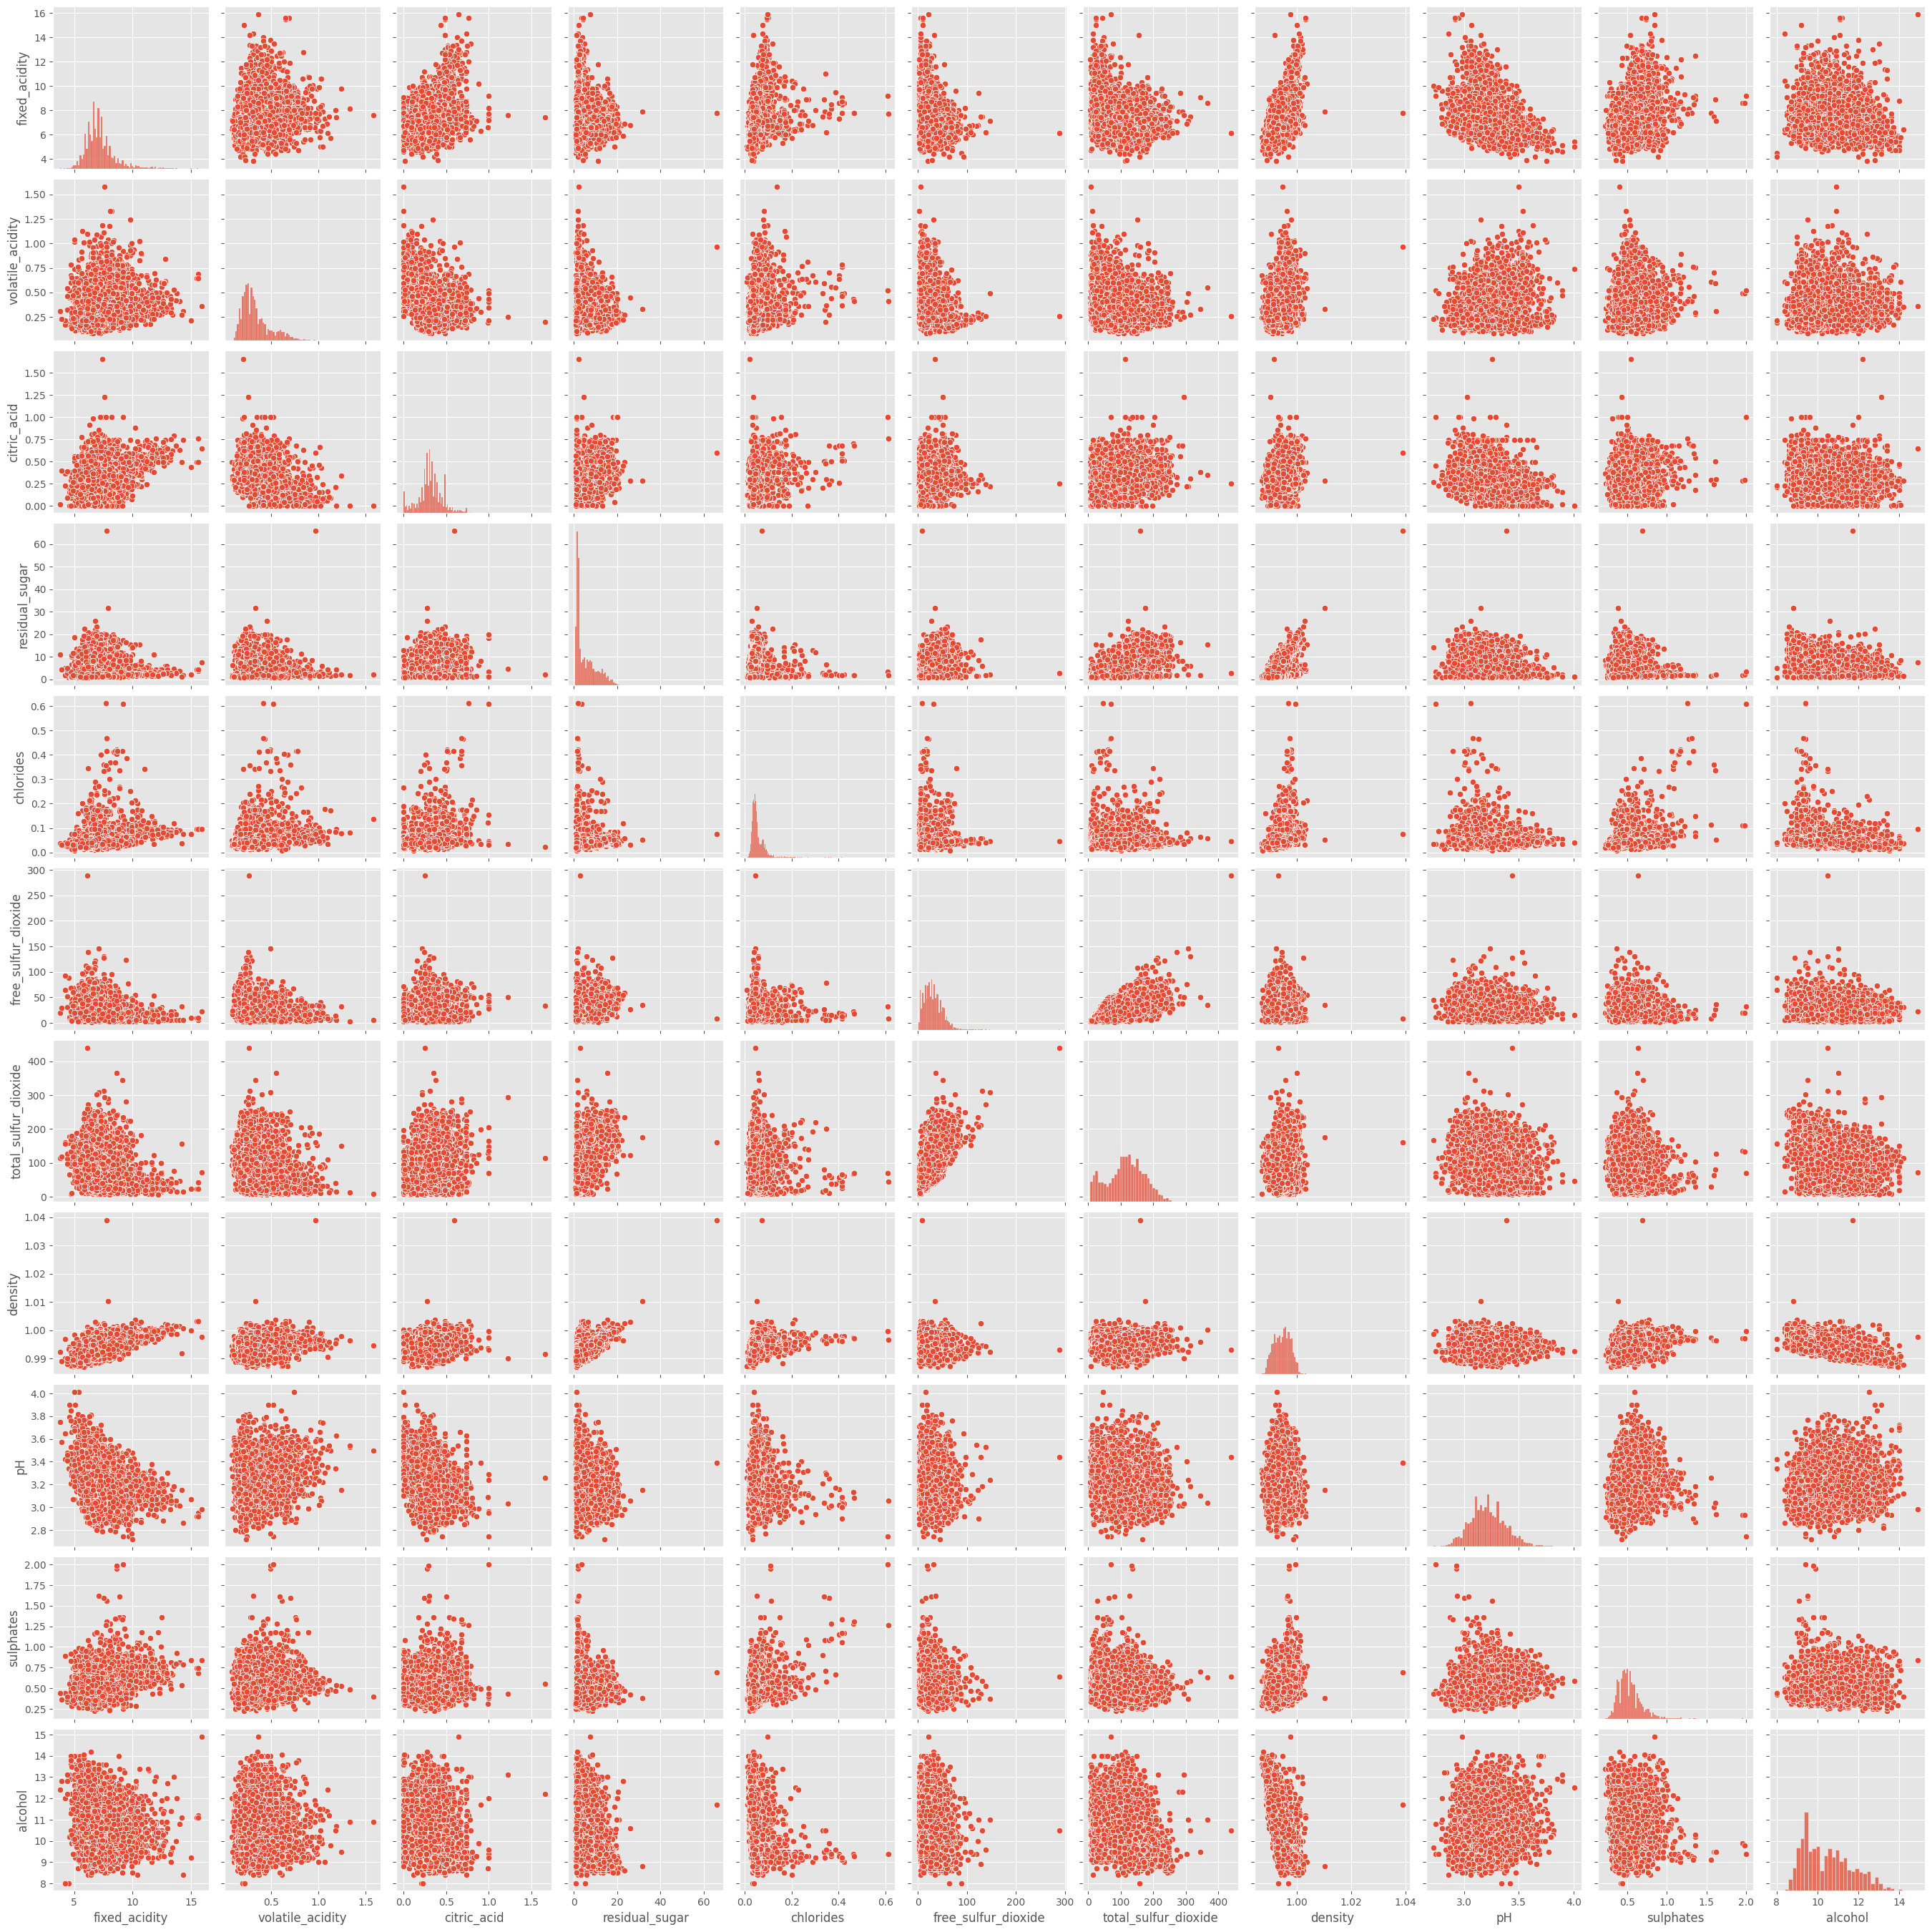

In [46]:
# plt.figure(figsize=(700, 700))
sns.pairplot(wq_X)

In [47]:
wq_y

quality
0           5
1           5
2           5
3           6
4           5
...       ...
6492        6
6493        5
6494        6
6495        7
6496        6

[6497 rows x 1 columns]

Checking for null values

In [48]:
print(wq_X.isnull().sum())
print(wq_y.isnull().sum())

fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
dtype: int64
quality    0
dtype: int64


In [49]:
wq_X.describe()


fixed_acidity  volatile_acidity  citric_acid  residual_sugar  \
count    6497.000000       6497.000000  6497.000000     6497.000000   
mean        7.215307          0.339666     0.318633        5.443235   
std         1.296434          0.164636     0.145318        4.757804   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.400000          0.230000     0.250000        1.800000   
50%         7.000000          0.290000     0.310000        3.000000   
75%         7.700000          0.400000     0.390000        8.100000   
max        15.900000          1.580000     1.660000       65.800000   

         chlorides  free_sulfur_dioxide  total_sulfur_dioxide      density  \
count  6497.000000          6497.000000           6497.000000  6497.000000   
mean      0.056034            30.525319            115.744574     0.994697   
std       0.035034            17.749400             56.521855     0.002999   
min       0.009000             1.000000              6.000000     0.987110   
25%       0.038000            17.000000             77.000000     0.992340   
50%       0.047000            29.000000            118.000000     0.994890   
75%       0.065000            41.000000            156.000000     0.996990   
max       0.611000           289.000000            440.000000     1.038980   

                pH    sulphates      alcohol  
count  6497.000000  6497.000000  6497.000000  
mean      3.218501     0.531268    10.491801  
std       0.160787     0.148806     1.192712  
min       2.720000     0.220000     8.000000  
25%       3.110000     0.430000     9.500000  
50%       3.210000     0.510000    10.300000  
75%       3.320000     0.600000    11.300000  
max       4.010000     2.000000    14.900000

Plotting boxplots to check whether there are any outliers

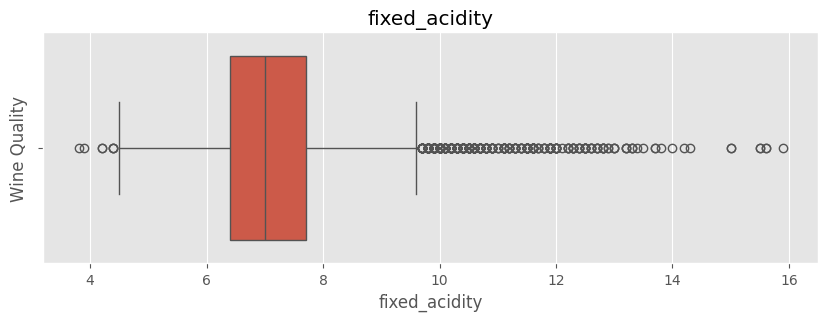

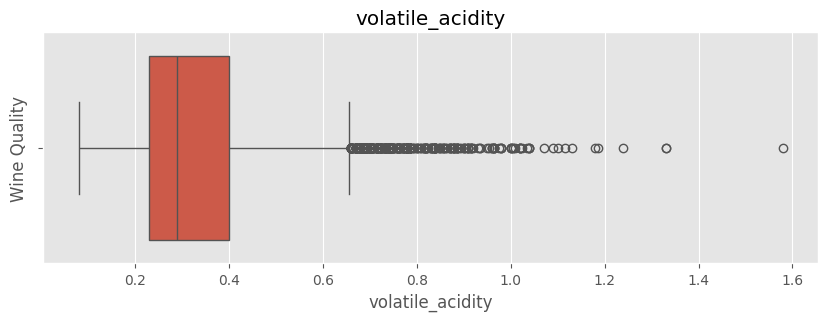

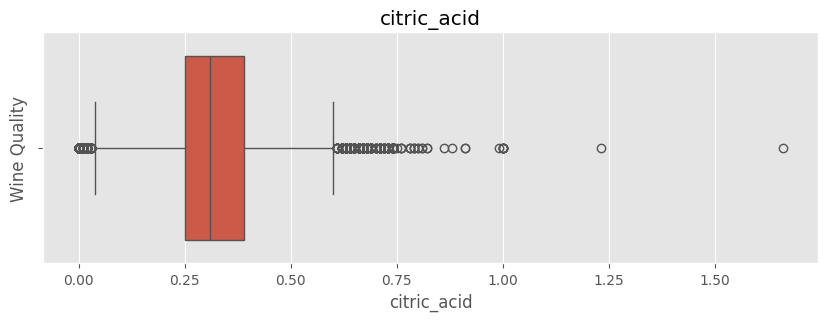

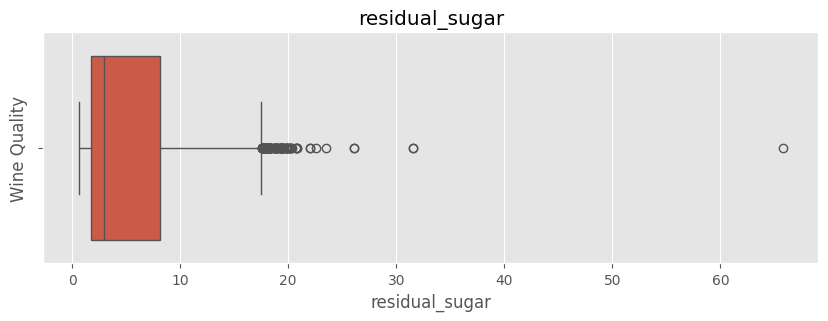

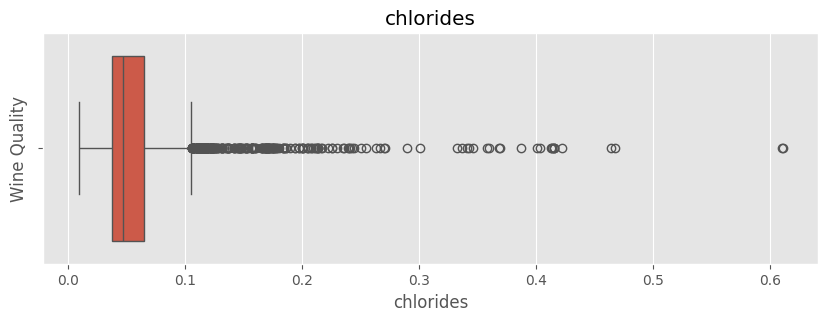

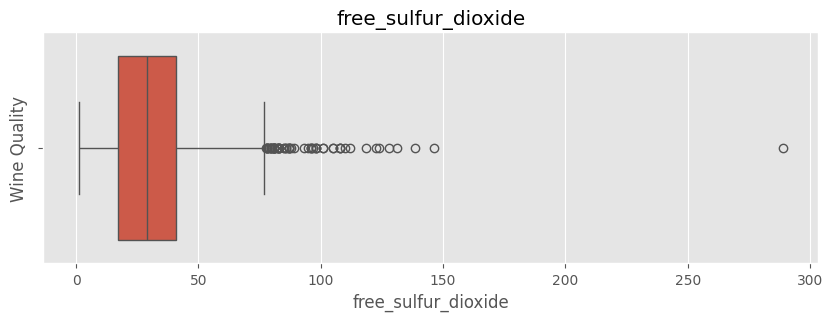

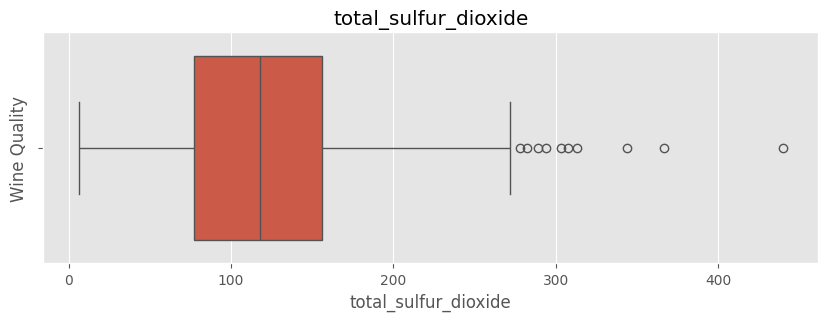

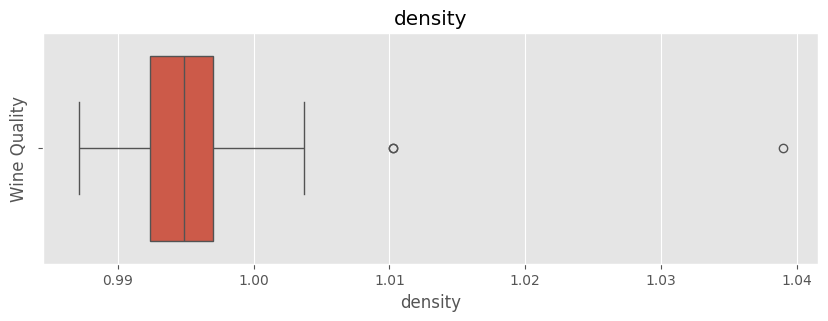

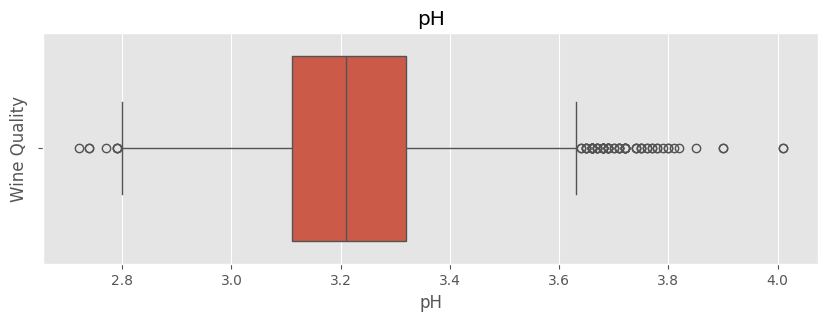

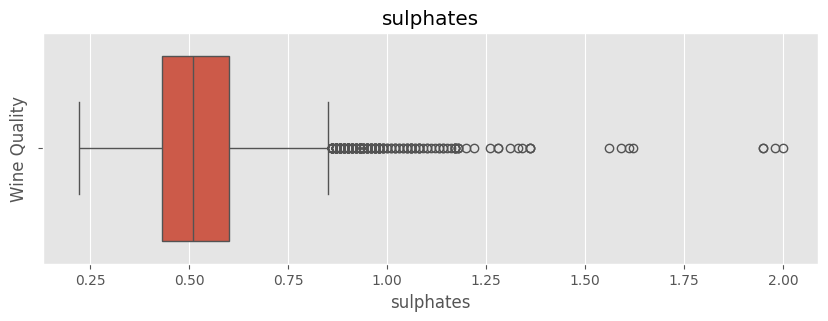

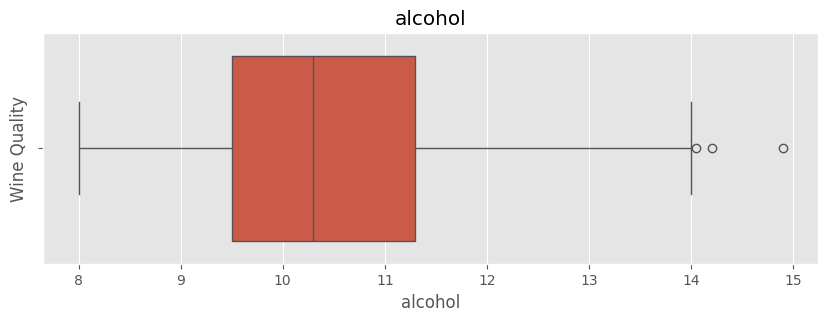

In [50]:
for column in wq_X.columns:
    plt.figure(figsize = (10,3))
    plt.title(column)
    sns.boxplot(wq_X[column], orient='y')
    plt.ylabel('Wine Quality')
    plt.xlabel(column)

Here all the features of the dataset have outliers present in them. 

Next, we remove the outliers using the $1.5 * IQR$ rule. Here we the cap the values according to the lower elimit and upper lemit.

In [51]:
def remove_outlier(df, columns):
    df_copy = df.copy()
    for column in columns:
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1

        upper_limit = q3 + (1.5 * iqr)
        lower_limit = q1 - (1.5 * iqr)

        df_copy.loc[df[column] > upper_limit, column] = upper_limit
        df_copy.loc[df[column] < lower_limit, column] = lower_limit
    return df_copy

Created a new dataframe from the features dataframe after removing outliers

In [52]:
new_df = remove_outlier(wq_X, wq_X.columns)

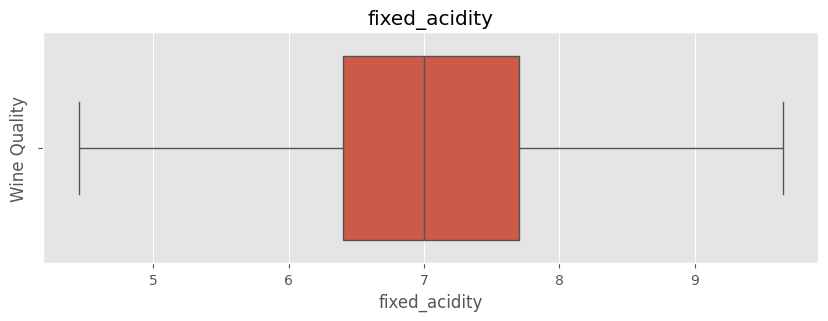

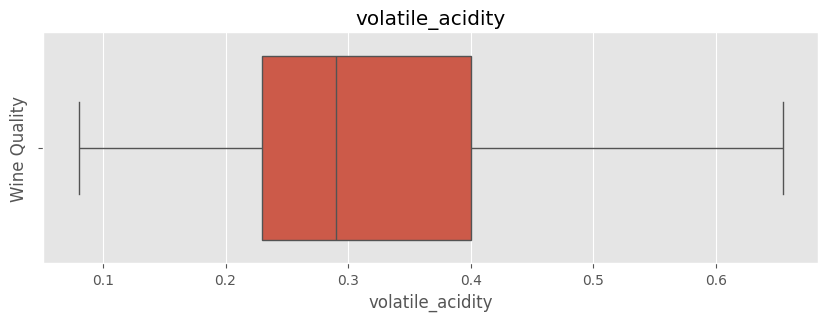

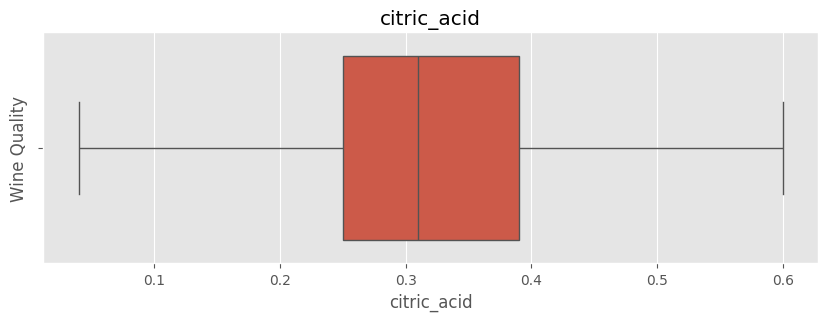

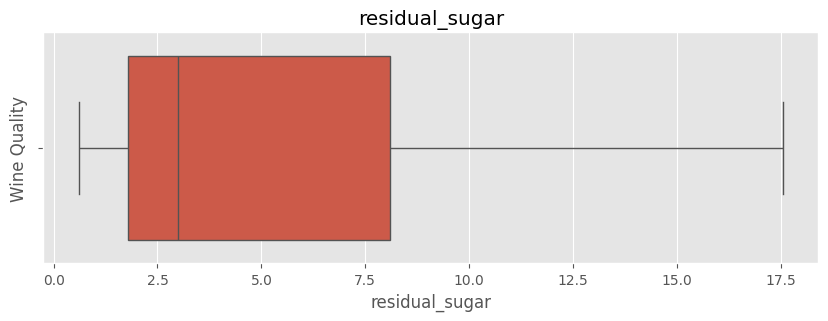

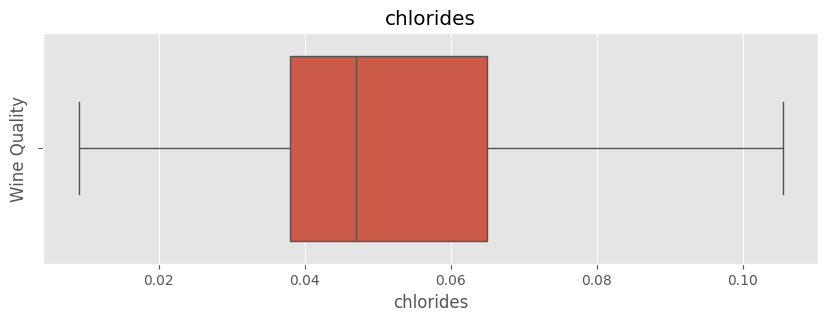

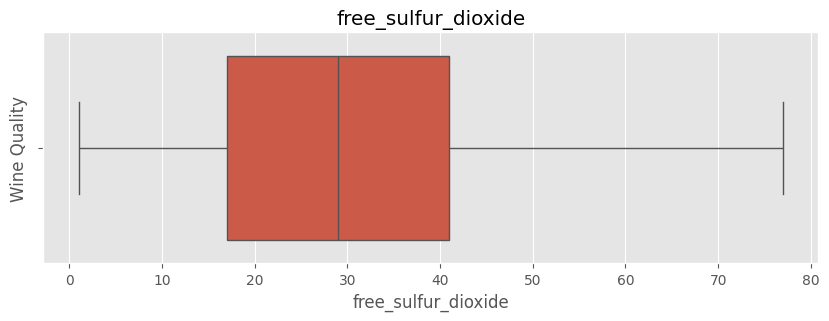

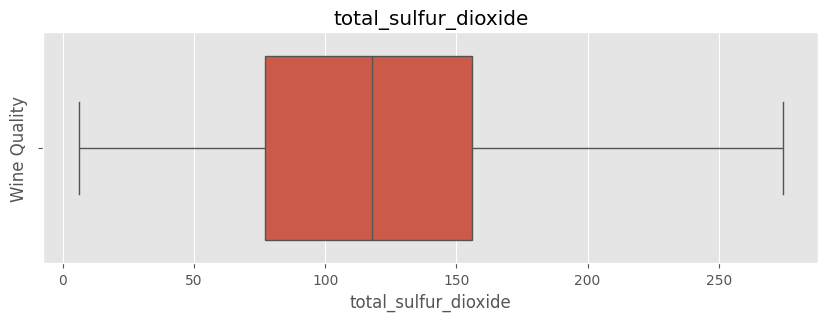

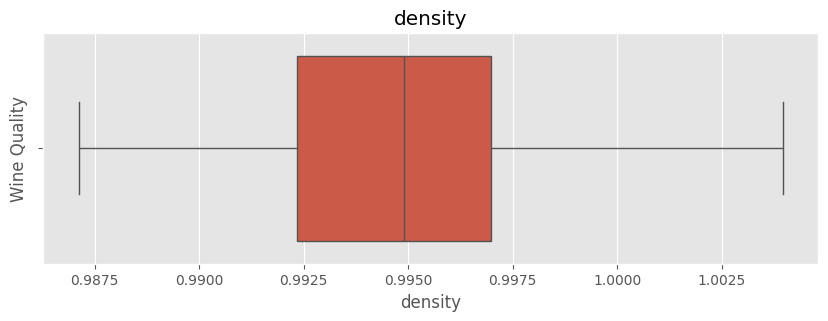

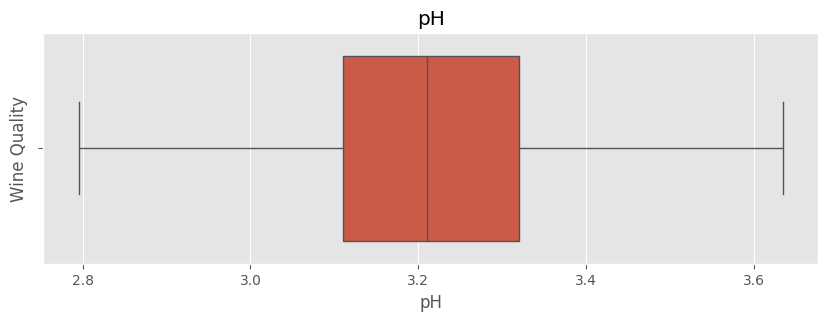

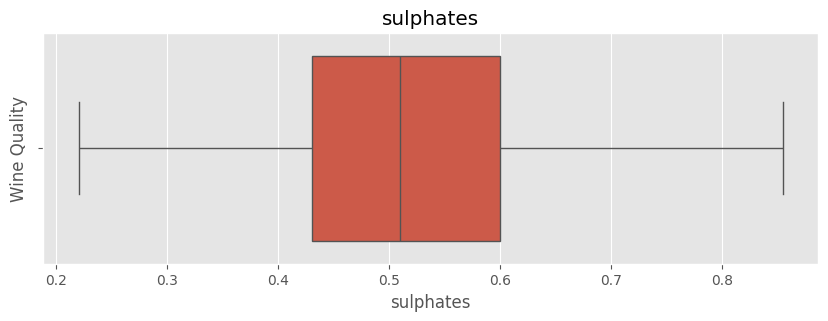

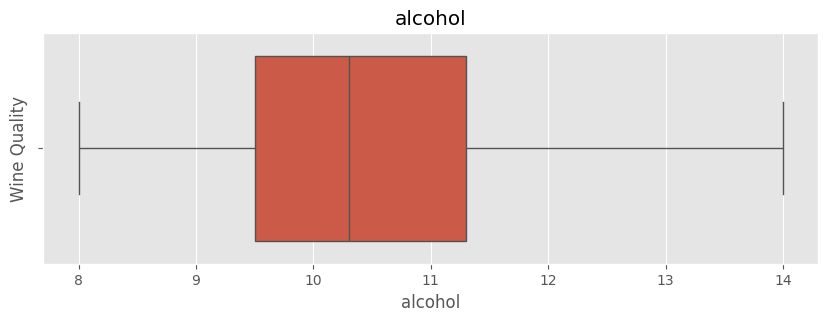

In [53]:
for column in new_df.columns:
    plt.figure(figsize = (10,3))
    plt.title(column)
    sns.boxplot(new_df[column], orient='y')
    plt.ylabel('Wine Quality')
    plt.xlabel(column)

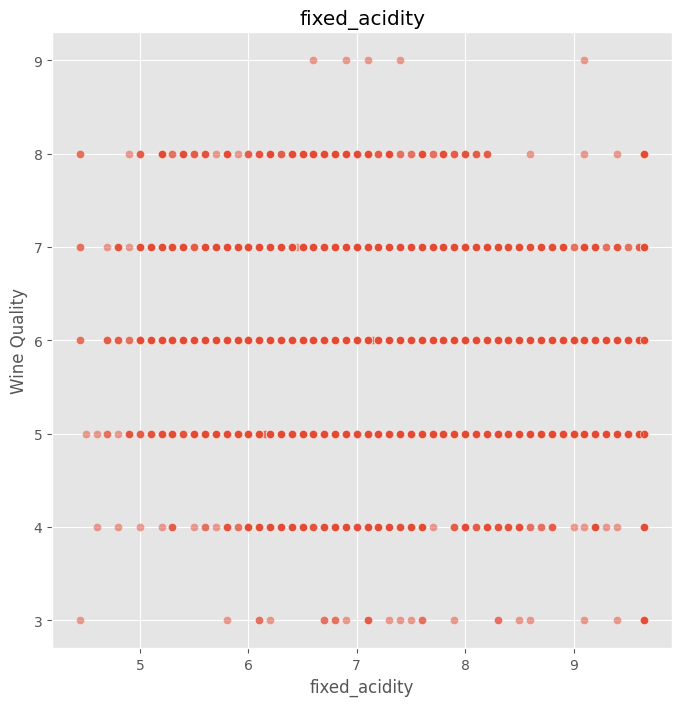

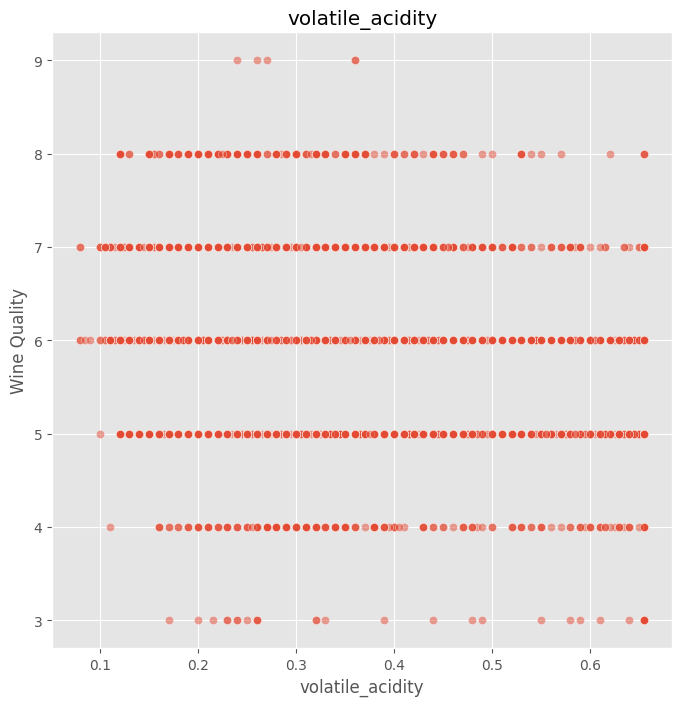

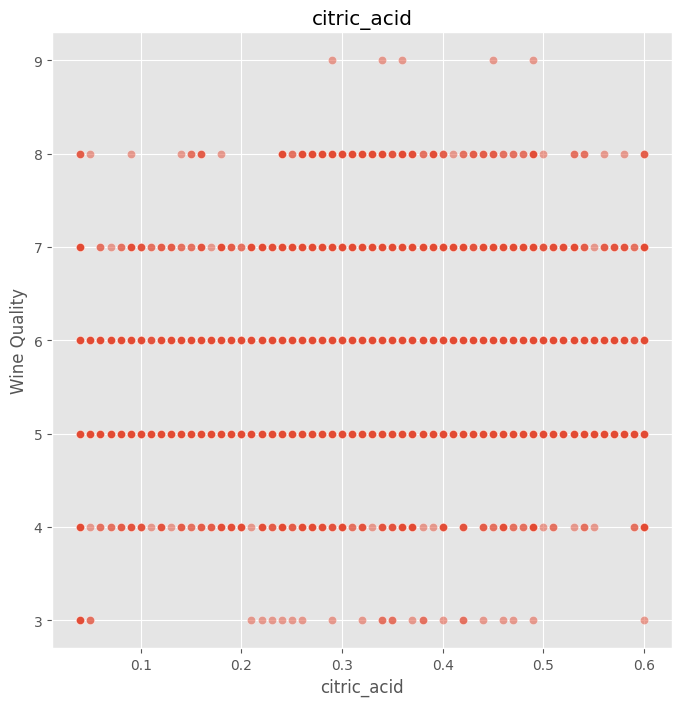

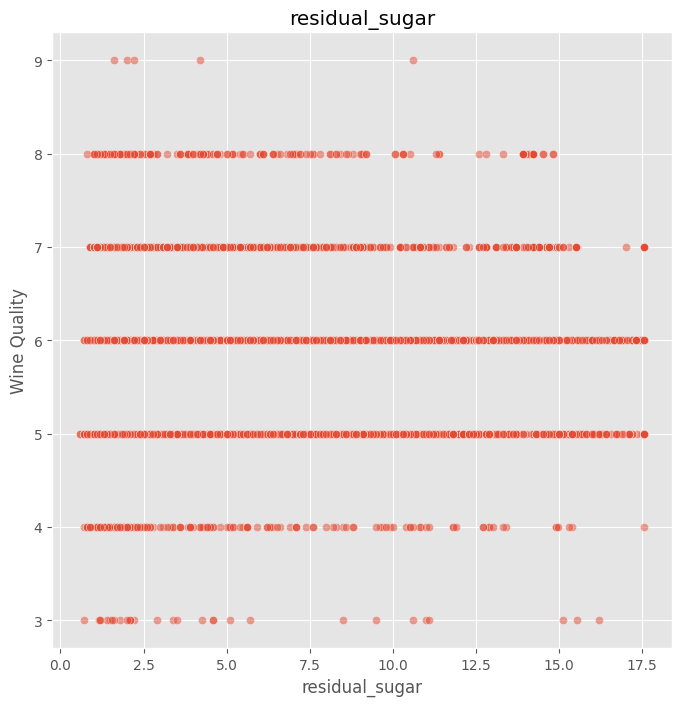

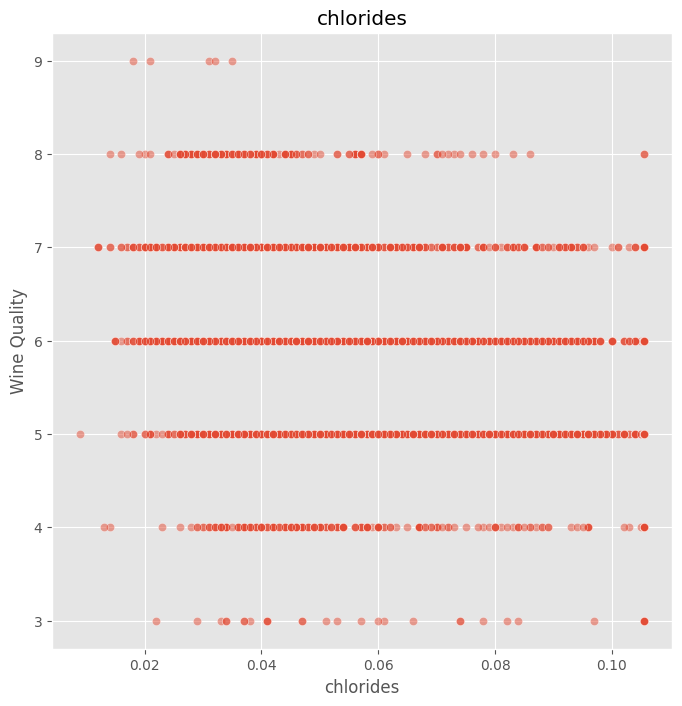

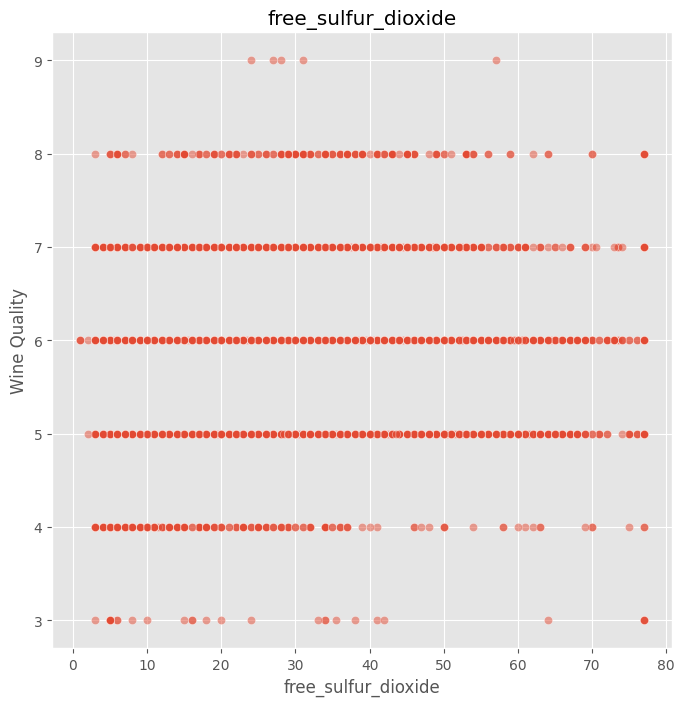

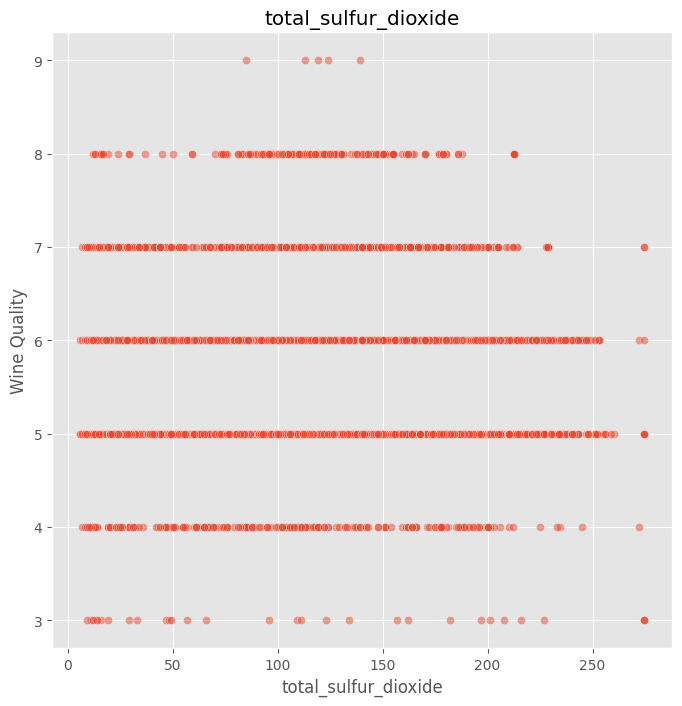

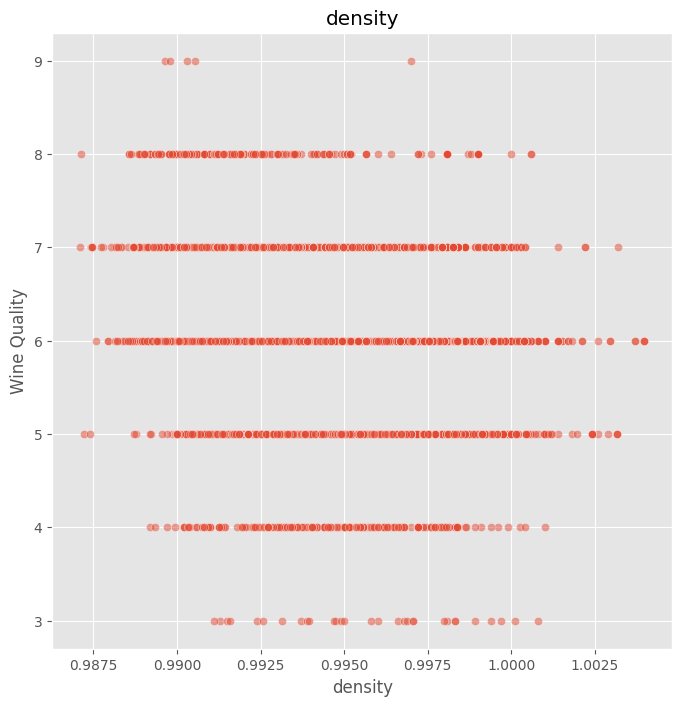

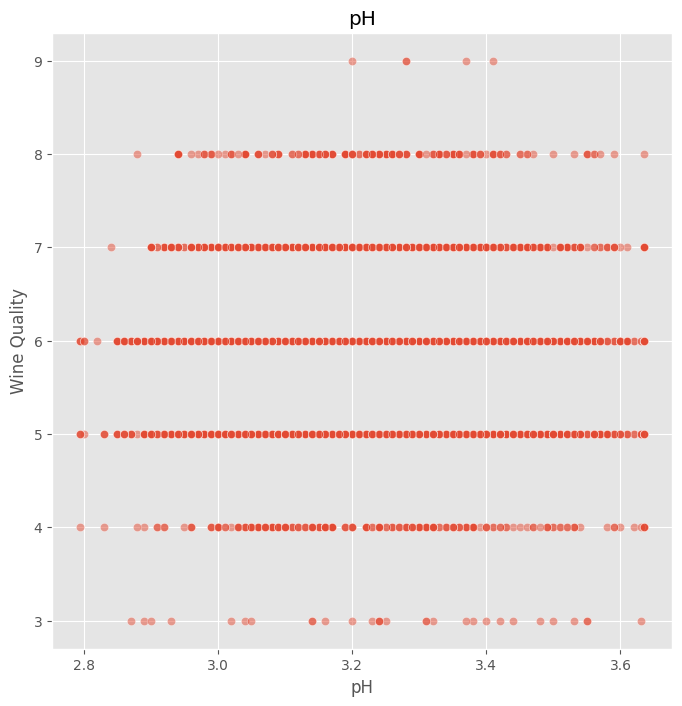

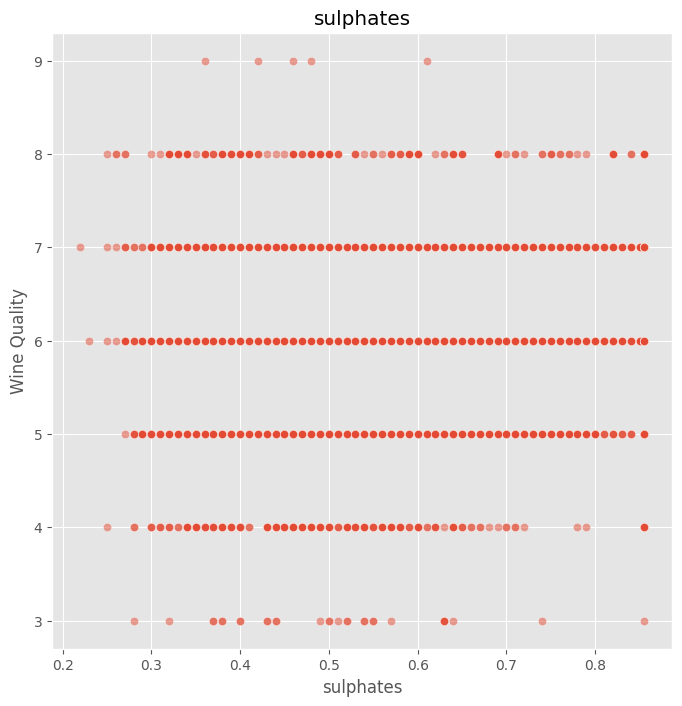

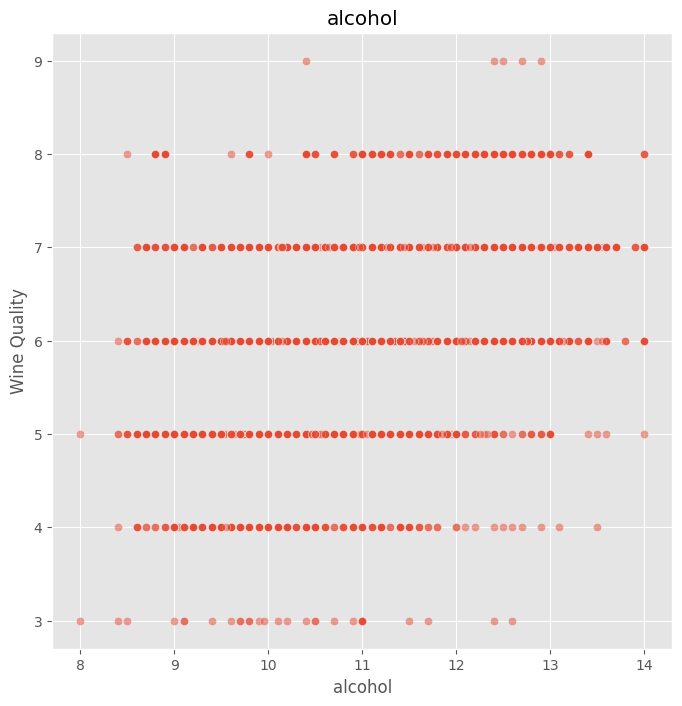

In [54]:
combined = pd.concat([new_df, wq_y], axis=1)
for column in new_df.columns:
    # column = wq_X_copy[column].to_numpy().ravel()
    plt.figure(figsize = (8,8))
    plt.title(column)
    sns.scatterplot(x=column, y="quality", alpha=0.5, data=combined)
    plt.ylabel('Wine Quality')
    plt.xlabel(column)
plt.show()

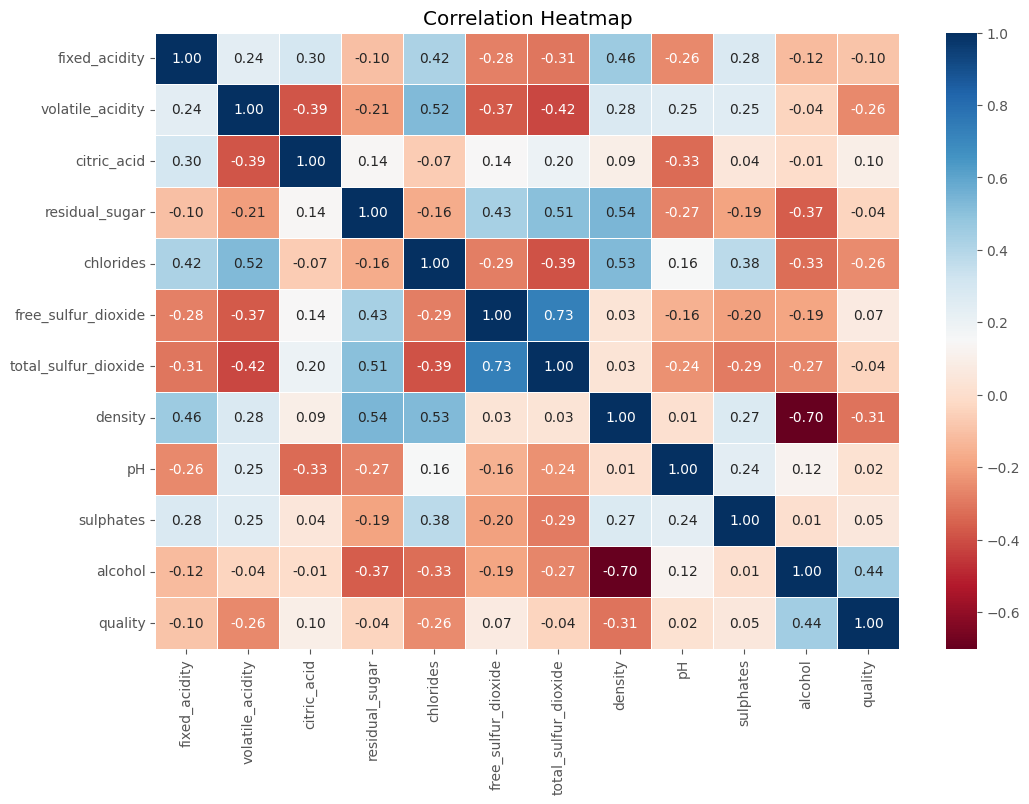

In [55]:
corr = combined.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='RdBu', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


In [56]:
scaler = StandardScaler()
new_df_scaled = scaler.fit_transform(new_df)

In [57]:
new_df_scaled

array([[ 0.2418641 ,  2.2331519 , -2.09471447, ...,  1.85169992,
         0.25409083, -0.91575791],
       [ 0.61709927,  2.2331519 , -2.09471447, ..., -0.11171274,
         1.16882486, -0.58019986],
       [ 0.61709927,  2.2331519 , -2.09471447, ...,  0.26830261,
         0.94014135, -0.58019986],
       ...,
       [-0.60241502, -0.64151455, -0.95702374, ..., -1.44176647,
        -0.50818753, -0.91575791],
       [-1.54050294, -0.29516919, -0.1227172 , ...,  0.77498975,
        -1.11801022,  1.93648552],
       [-1.07145898, -0.84932176,  0.48405119, ...,  0.26830261,
        -1.57537723,  1.0975904 ]], shape=(6497, 11))

In [58]:
wq_y.to_numpy().flatten()

array([5, 5, 5, ..., 6, 7, 6], shape=(6497,))

Performing Linear Discriminant Analysis on the scaled dataset.

In [59]:
lda = LinearDiscriminantAnalysis(solver = "eigen", n_components=6)
lda_transformed = lda.fit_transform(new_df_scaled, wq_y.to_numpy().flatten())


In [60]:
lda.explained_variance_ratio_

array([0.90469665, 0.06381106, 0.01876095, 0.00675753, 0.00435832,
       0.0016155 ])

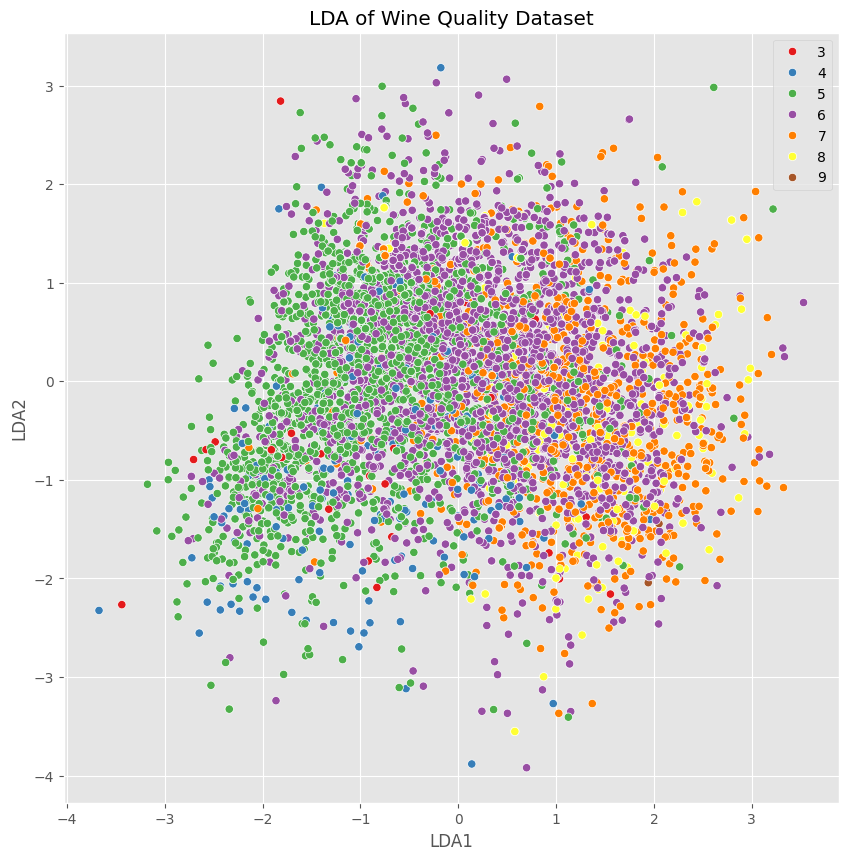

In [61]:

plt.figure(figsize=(10, 10))
plt.xlabel('LDA1')
plt.ylabel('LDA2')
sns.scatterplot(x = lda_transformed[:, 0], y = lda_transformed[:, 1], hue = wq_y.to_numpy().flatten(), palette = 'Set1')
plt.title('LDA of Wine Quality Dataset')
plt.show()

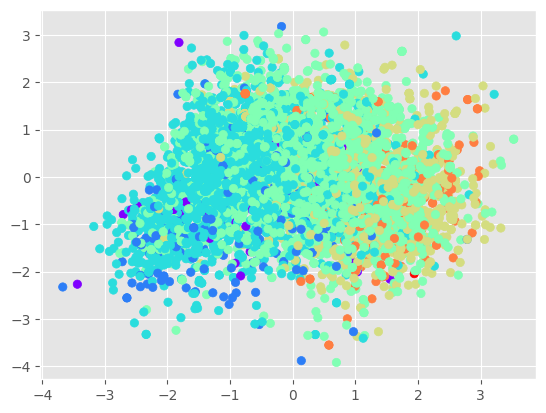

In [62]:
plt.scatter(lda_transformed[:, 0], lda_transformed[:, 1], c = wq_y.to_numpy().flatten(), cmap = 'rainbow')

In [63]:
fig = px.scatter_3d(
    x=lda_transformed[:, 0],
    y=lda_transformed[:, 1],
    z=lda_transformed[:, 2],
    # symbol=wq_y.to_numpy().flatten(),
    color=wq_y.to_numpy().flatten(),
    labels={'x': 'LDA1', 'y': 'LDA2', 'z': 'LDA3'},
    title='3D PCA Scatter Plot',
    color_continuous_scale=px.colors.sequential.Blackbody
)
fig.update_layout(margin=dict(l = 0, r = 0, b = 0, t =100), width = 1000, height = 800)

dataset 2

In [18]:
dataset = pd.read_csv("datasets/diabetes.csv")
dataset



Diabetes_012  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0                0.0     1.0       1.0        1.0  40.0     1.0     0.0   
1                0.0     0.0       0.0        0.0  25.0     1.0     0.0   
2                0.0     1.0       1.0        1.0  28.0     0.0     0.0   
3                0.0     1.0       0.0        1.0  27.0     0.0     0.0   
4                0.0     1.0       1.0        1.0  24.0     0.0     0.0   
...              ...     ...       ...        ...   ...     ...     ...   
253675           0.0     1.0       1.0        1.0  45.0     0.0     0.0   
253676           2.0     1.0       1.0        1.0  18.0     0.0     0.0   
253677           0.0     0.0       0.0        1.0  28.0     0.0     0.0   
253678           0.0     1.0       0.0        1.0  23.0     0.0     0.0   
253679           2.0     1.0       1.0        1.0  25.0     0.0     0.0   

        HeartDiseaseorAttack  PhysActivity  Fruits  ...  AnyHealthcare  \
0                        0.0           0.0     0.0  ...            1.0   
1                        0.0           1.0     0.0  ...            0.0   
2                        0.0           0.0     1.0  ...            1.0   
3                        0.0           1.0     1.0  ...            1.0   
4                        0.0           1.0     1.0  ...            1.0   
...                      ...           ...     ...  ...            ...   
253675                   0.0           0.0     1.0  ...            1.0   
253676                   0.0           0.0     0.0  ...            1.0   
253677                   0.0           1.0     1.0  ...            1.0   
253678                   0.0           0.0     1.0  ...            1.0   
253679                   1.0           1.0     1.0  ...            1.0   

        NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk  Sex   Age  \
0               0.0      5.0      18.0      15.0       1.0  0.0   9.0   
1               1.0      3.0       0.0       0.0       0.0  0.0   7.0   
2               1.0      5.0      30.0      30.0       1.0  0.0   9.0   
3               0.0      2.0       0.0       0.0       0.0  0.0  11.0   
4               0.0      2.0       3.0       0.0       0.0  0.0  11.0   
...             ...      ...       ...       ...       ...  ...   ...   
253675          0.0      3.0       0.0       5.0       0.0  1.0   5.0   
253676          0.0      4.0       0.0       0.0       1.0  0.0  11.0   
253677          0.0      1.0       0.0       0.0       0.0  0.0   2.0   
253678          0.0      3.0       0.0       0.0       0.0  1.0   7.0   
253679          0.0      2.0       0.0       0.0       0.0  0.0   9.0   

        Education  Income  
0             4.0     3.0  
1             6.0     1.0  
2             4.0     8.0  
3             3.0     6.0  
4             5.0     4.0  
...           ...     ...  
253675        6.0     7.0  
253676        2.0     4.0  
253677        5.0     2.0  
253678        5.0     1.0  
253679        6.0     2.0  

[253680 rows x 22 columns]

In [19]:
dataset.describe()

Diabetes_012         HighBP       HighChol      CholCheck  \
count  253680.000000  253680.000000  253680.000000  253680.000000   
mean        0.296921       0.429001       0.424121       0.962670   
std         0.698160       0.494934       0.494210       0.189571   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       1.000000   
50%         0.000000       0.000000       0.000000       1.000000   
75%         0.000000       1.000000       1.000000       1.000000   
max         2.000000       1.000000       1.000000       1.000000   

                 BMI         Smoker         Stroke  HeartDiseaseorAttack  \
count  253680.000000  253680.000000  253680.000000         253680.000000   
mean       28.382364       0.443169       0.040571              0.094186   
std         6.608694       0.496761       0.197294              0.292087   
min        12.000000       0.000000       0.000000              0.000000   
25%        24.000000       0.000000       0.000000              0.000000   
50%        27.000000       0.000000       0.000000              0.000000   
75%        31.000000       1.000000       0.000000              0.000000   
max        98.000000       1.000000       1.000000              1.000000   

        PhysActivity         Fruits  ...  AnyHealthcare    NoDocbcCost  \
count  253680.000000  253680.000000  ...  253680.000000  253680.000000   
mean        0.756544       0.634256  ...       0.951053       0.084177   
std         0.429169       0.481639  ...       0.215759       0.277654   
min         0.000000       0.000000  ...       0.000000       0.000000   
25%         1.000000       0.000000  ...       1.000000       0.000000   
50%         1.000000       1.000000  ...       1.000000       0.000000   
75%         1.000000       1.000000  ...       1.000000       0.000000   
max         1.000000       1.000000  ...       1.000000       1.000000   

             GenHlth       MentHlth       PhysHlth       DiffWalk  \
count  253680.000000  253680.000000  253680.000000  253680.000000   
mean        2.511392       3.184772       4.242081       0.168224   
std         1.068477       7.412847       8.717951       0.374066   
min         1.000000       0.000000       0.000000       0.000000   
25%         2.000000       0.000000       0.000000       0.000000   
50%         2.000000       0.000000       0.000000       0.000000   
75%         3.000000       2.000000       3.000000       0.000000   
max         5.000000      30.000000      30.000000       1.000000   

                 Sex            Age      Education         Income  
count  253680.000000  253680.000000  253680.000000  253680.000000  
mean        0.440342       8.032119       5.050434       6.053875  
std         0.496429       3.054220       0.985774       2.071148  
min         0.000000       1.000000       1.000000       1.000000  
25%         0.000000       6.000000       4.000000       5.000000  
50%         0.000000       8.000000       5.000000       7.000000  
75%         1.000000      10.000000       6.000000       8.000000  
max         1.000000      13.000000       6.000000       8.000000  

[8 rows x 22 columns]

In [20]:
dataset.var()

Diabetes_012             0.487427
HighBP                   0.244960
HighChol                 0.244243
CholCheck                0.035937
BMI                     43.674839
Smoker                   0.246771
Stroke                   0.038925
HeartDiseaseorAttack     0.085315
PhysActivity             0.184186
Fruits                   0.231976
Veggies                  0.153018
HvyAlcoholConsump        0.053039
AnyHealthcare            0.046552
NoDocbcCost              0.077091
GenHlth                  1.141644
MentHlth                54.950296
PhysHlth                76.002675
DiffWalk                 0.139925
Sex                      0.246442
Age                      9.328262
Education                0.971751
Income                   4.289652
dtype: float64

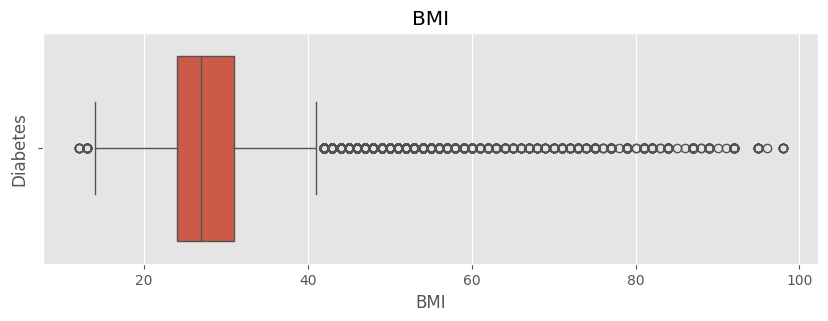

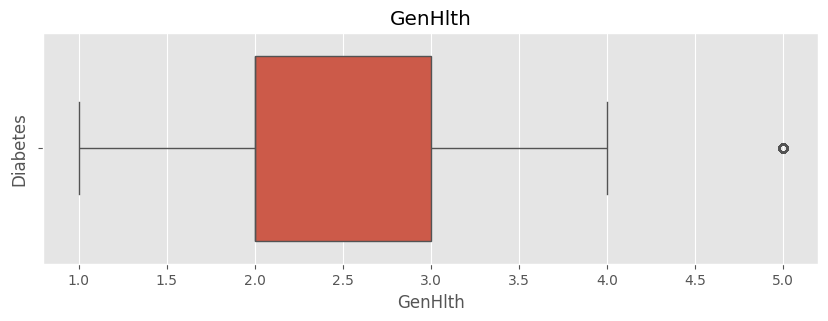

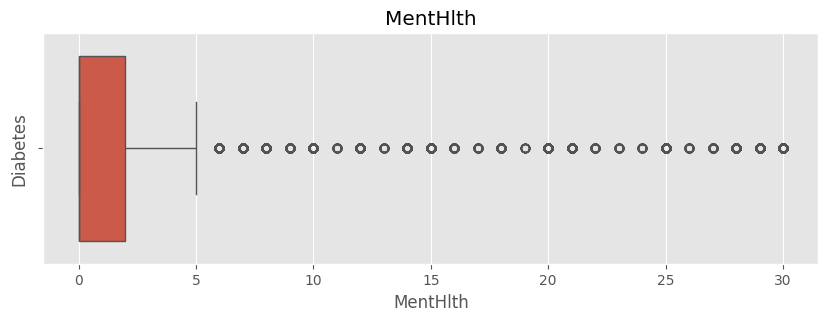

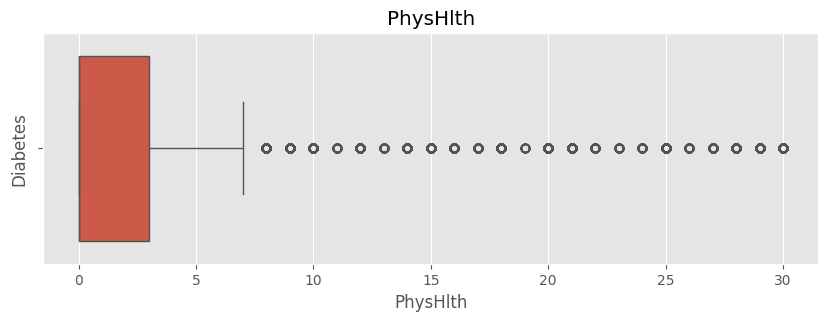

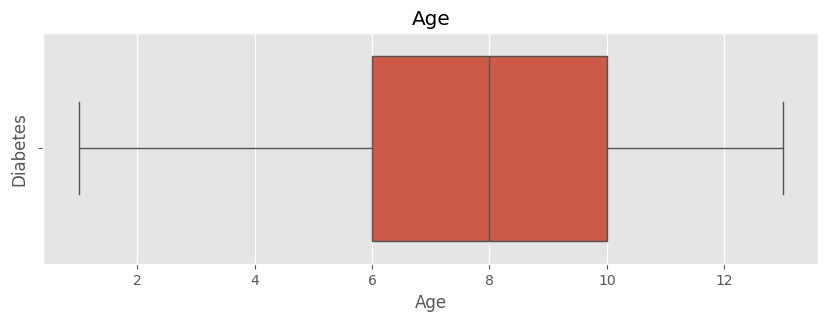

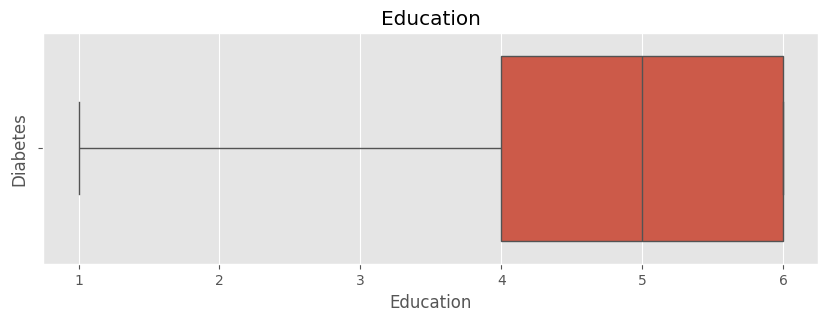

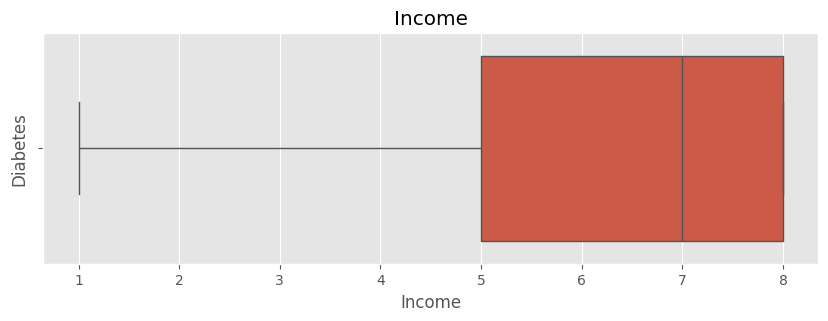

In [21]:
for column in ["BMI", "GenHlth", "MentHlth", "PhysHlth", "Age", "Education", "Income"]:
    plt.figure(figsize = (10,3))
    plt.title(column)
    sns.boxplot(dataset[column], orient='y')
    plt.ylabel('Diabetes')
    plt.xlabel(column)

In [22]:
def remove_outlier(df, columns):
    df_copy = df.copy()
    for column in columns:
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1

        upper_limit = q3 + (1.5 * iqr)
        lower_limit = q1 - (1.5 * iqr)

        df_copy.loc[df[column] > upper_limit, column] = upper_limit
        df_copy.loc[df[column] < lower_limit, column] = lower_limit
    return df_copy

new_df = remove_outlier(dataset, ["BMI", "GenHlth", "MentHlth", "PhysHlth", "Age", "Income"])

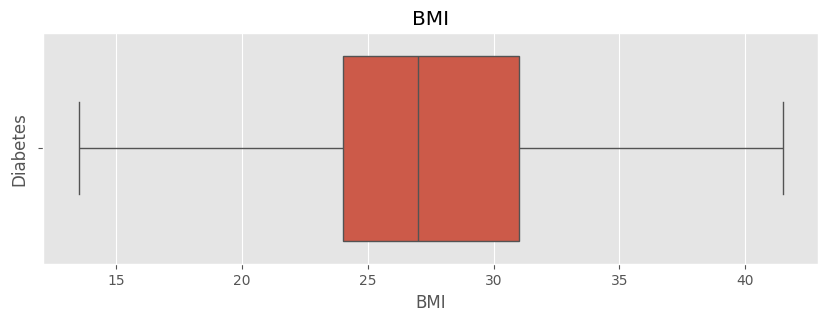

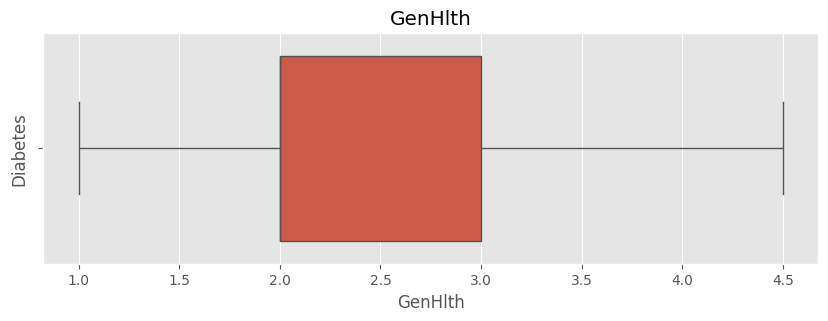

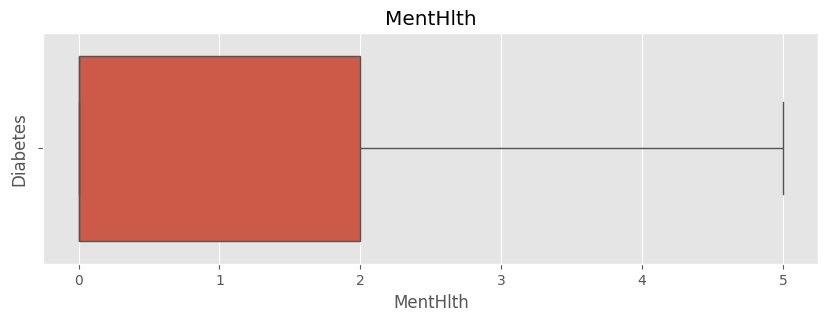

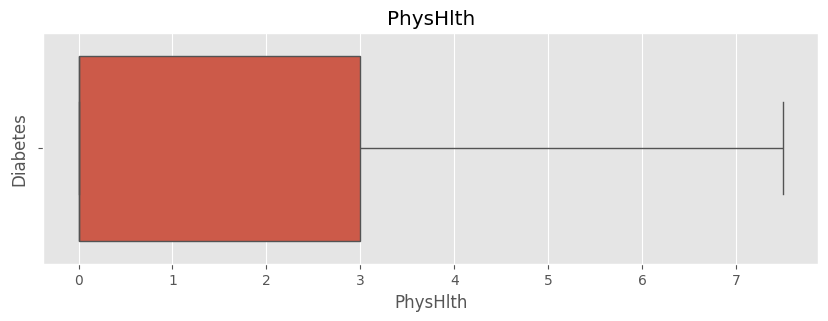

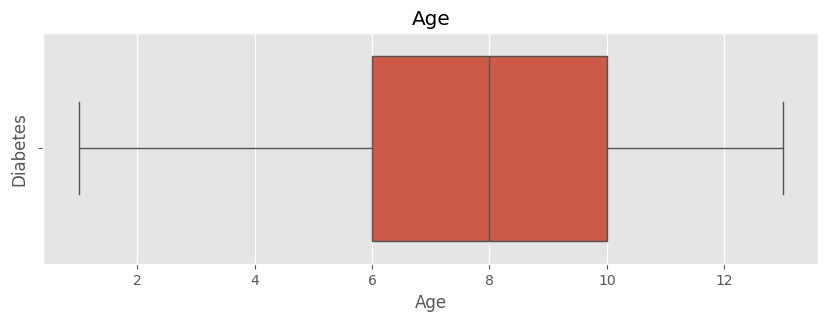

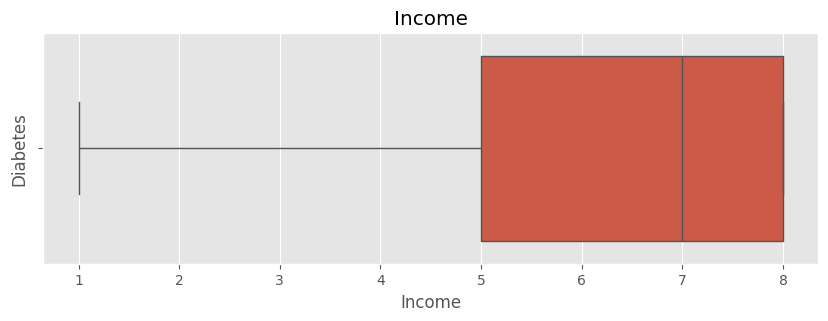

In [23]:
for column in ["BMI", "GenHlth", "MentHlth", "PhysHlth", "Age", "Income"]:
    plt.figure(figsize = (10,3))
    plt.title(column)
    sns.boxplot(new_df[column], orient='y')
    plt.ylabel('Diabetes')
    plt.xlabel(column)

In [24]:
scaler = StandardScaler()
new_df_scaled = scaler.fit_transform(new_df[["BMI", "GenHlth", "MentHlth", "PhysHlth", "Age","Education", "Income"]])
new_df_scaled

array([[ 2.13816025,  1.97861332,  1.9576051 , ...,  0.31690008,
        -1.06559465, -1.4744874 ],
       [-0.55864213,  0.50381125, -0.6015167 , ..., -0.33793279,
         0.96327159, -2.44013754],
       [-0.01928166,  1.97861332,  1.9576051 , ...,  0.31690008,
        -1.06559465,  0.93963796],
       ...,
       [-0.01928166, -1.4625915 , -0.6015167 , ..., -1.97501498,
        -0.05116153, -1.95731247],
       [-0.91821578,  0.50381125, -0.6015167 , ..., -0.33793279,
        -0.05116153, -2.44013754],
       [-0.55864213, -0.47939012, -0.6015167 , ...,  0.31690008,
         0.96327159, -1.95731247]], shape=(253680, 7))

In [25]:
new_df_scaled = pd.DataFrame(new_df_scaled, columns=["BMI", "GenHlth", "MentHlth", "PhysHlth", "Age","Education", "Income"])
new_df_scaled

BMI   GenHlth  MentHlth  PhysHlth       Age  Education    Income
0       2.138160  1.978613  1.957605  1.956593  0.316900  -1.065595 -1.474487
1      -0.558642  0.503811 -0.601517 -0.641079 -0.337933   0.963272 -2.440138
2      -0.019282  1.978613  1.957605  1.956593  0.316900  -1.065595  0.939638
3      -0.199068 -0.479390 -0.601517 -0.641079  0.971733  -2.080028 -0.026012
4      -0.738429 -0.479390  0.933956 -0.641079  0.971733  -0.051162 -0.991662
...          ...       ...       ...       ...       ...        ...       ...
253675  2.407840  0.503811 -0.601517  1.090702 -0.992766   0.963272  0.456813
253676 -1.817150  1.487013 -0.601517 -0.641079  0.971733  -3.094461 -0.991662
253677 -0.019282 -1.462592 -0.601517 -0.641079 -1.975015  -0.051162 -1.957312
253678 -0.918216  0.503811 -0.601517 -0.641079 -0.337933  -0.051162 -2.440138
253679 -0.558642 -0.479390 -0.601517 -0.641079  0.316900   0.963272 -1.957312

[253680 rows x 7 columns]

In [26]:
dataset = dataset.drop(columns=["BMI", "GenHlth", "MentHlth", "PhysHlth", "Age","Education", "Income"])
dataset = pd.concat([dataset, new_df_scaled], axis=1)
dataset

Diabetes_012  HighBP  HighChol  CholCheck  Smoker  Stroke  \
0                0.0     1.0       1.0        1.0     1.0     0.0   
1                0.0     0.0       0.0        0.0     1.0     0.0   
2                0.0     1.0       1.0        1.0     0.0     0.0   
3                0.0     1.0       0.0        1.0     0.0     0.0   
4                0.0     1.0       1.0        1.0     0.0     0.0   
...              ...     ...       ...        ...     ...     ...   
253675           0.0     1.0       1.0        1.0     0.0     0.0   
253676           2.0     1.0       1.0        1.0     0.0     0.0   
253677           0.0     0.0       0.0        1.0     0.0     0.0   
253678           0.0     1.0       0.0        1.0     0.0     0.0   
253679           2.0     1.0       1.0        1.0     0.0     0.0   

        HeartDiseaseorAttack  PhysActivity  Fruits  Veggies  ...  NoDocbcCost  \
0                        0.0           0.0     0.0      1.0  ...          0.0   
1                        0.0           1.0     0.0      0.0  ...          1.0   
2                        0.0           0.0     1.0      0.0  ...          1.0   
3                        0.0           1.0     1.0      1.0  ...          0.0   
4                        0.0           1.0     1.0      1.0  ...          0.0   
...                      ...           ...     ...      ...  ...          ...   
253675                   0.0           0.0     1.0      1.0  ...          0.0   
253676                   0.0           0.0     0.0      0.0  ...          0.0   
253677                   0.0           1.0     1.0      0.0  ...          0.0   
253678                   0.0           0.0     1.0      1.0  ...          0.0   
253679                   1.0           1.0     1.0      0.0  ...          0.0   

        DiffWalk  Sex       BMI   GenHlth  MentHlth  PhysHlth       Age  \
0            1.0  0.0  2.138160  1.978613  1.957605  1.956593  0.316900   
1            0.0  0.0 -0.558642  0.503811 -0.601517 -0.641079 -0.337933   
2            1.0  0.0 -0.019282  1.978613  1.957605  1.956593  0.316900   
3            0.0  0.0 -0.199068 -0.479390 -0.601517 -0.641079  0.971733   
4            0.0  0.0 -0.738429 -0.479390  0.933956 -0.641079  0.971733   
...          ...  ...       ...       ...       ...       ...       ...   
253675       0.0  1.0  2.407840  0.503811 -0.601517  1.090702 -0.992766   
253676       1.0  0.0 -1.817150  1.487013 -0.601517 -0.641079  0.971733   
253677       0.0  0.0 -0.019282 -1.462592 -0.601517 -0.641079 -1.975015   
253678       0.0  1.0 -0.918216  0.503811 -0.601517 -0.641079 -0.337933   
253679       0.0  0.0 -0.558642 -0.479390 -0.601517 -0.641079  0.316900   

        Education    Income  
0       -1.065595 -1.474487  
1        0.963272 -2.440138  
2       -1.065595  0.939638  
3       -2.080028 -0.026012  
4       -0.051162 -0.991662  
...           ...       ...  
253675   0.963272  0.456813  
253676  -3.094461 -0.991662  
253677  -0.051162 -1.957312  
253678  -0.051162 -2.440138  
253679   0.963272 -1.957312  

[253680 rows x 22 columns]

In [30]:
db_X = dataset.drop(columns=["Diabetes_012"])
db_y = dataset["Diabetes_012"]

In [40]:
lda = LinearDiscriminantAnalysis(solver="eigen",n_components=2)
lda_transformed = lda.fit_transform(db_X, db_y)
lda.explained_variance_ratio_

array([0.99357664, 0.00642336])

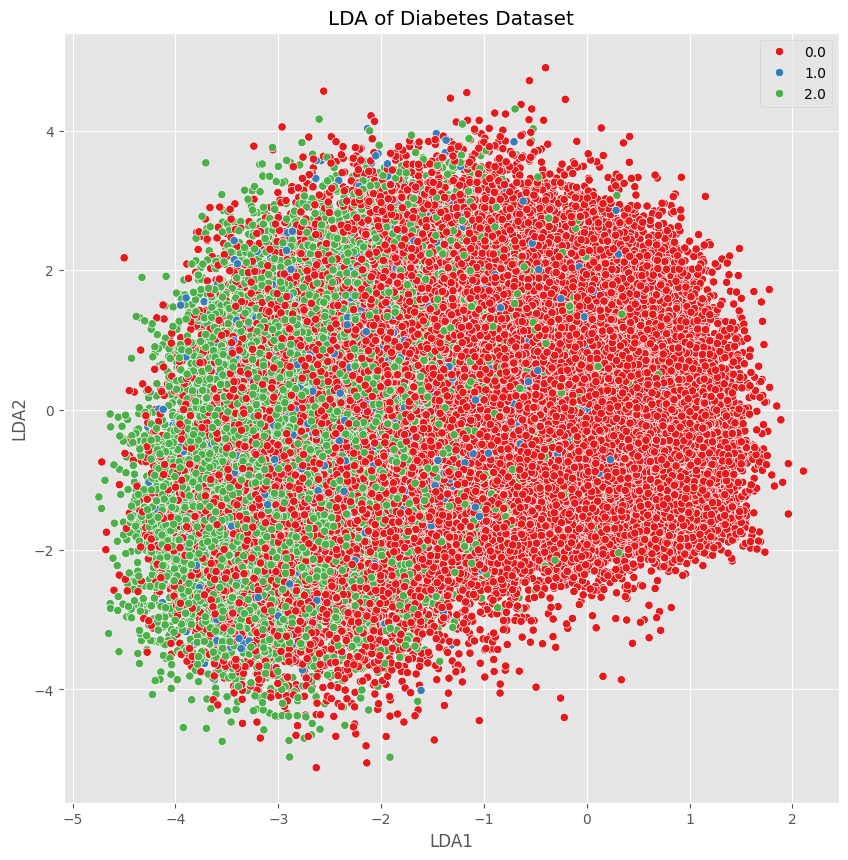

In [41]:

plt.figure(figsize=(10, 10))
plt.xlabel('LDA1')
plt.ylabel('LDA2')
sns.scatterplot(x = lda_transformed[:, 0], y = lda_transformed[:, 1], hue = db_y.to_numpy().flatten(), palette = 'Set1')
plt.title('LDA of Diabetes Dataset')
plt.show()